In [1]:
using DynamicalSystems
using DifferentialEquations
using OrdinaryDiffEq
using StaticArrays
using Statistics
using JLD

In [2]:
function sigma(x)
    return 1.0 / ( 1.0 + exp( -10.0 * ( x  - ( - 0.25 ) ) ) )
end

function HR(u, p, t)
        
    a, b, c, d, s, xr, r,  I, vs, k1, k2, el_link  = p
    x1, y1, z1, x2, y2, z2 = u
    
    du1 = y1 + b * x1 ^ 2 - a * x1 ^3 - z1 + I - k1 * ( x1 - vs ) * sigma(x2) + el_link * ( x2 - x1 )
    du2 = c - d * x1 ^2 - y1
    du3 = r * ( s * ( x1 - xr ) - z1 )
    
    du4 = y2 + b * x2 ^ 2 - a * x2 ^3 - z2 + I - k2 * ( x2 - vs ) * sigma(x1) + el_link * ( x1 - x2 )
    du5 = c - d * x2 ^2 - y2
    du6 = r * ( s * ( x2 - xr ) - z2 )
    return SVector(du1, du2, du3,
                    du4, du5, du6)
end

HR (generic function with 1 method)

In [3]:
function CALCPDF(spikes)
    ϵ = 0.9
    ee_counter = [sum(i->s<=i<s+ϵ, spikes) for s in range(0,4,5000000)]
    pdf = ee_counter ./ length(spikes)
    return range(0,4,5000000), pdf
end

CALCPDF (generic function with 1 method)

In [4]:
a = 1.0; b = 3.0; c = 1.0; d = 5.0
xr = -1.6; r = 0.01; s = 5.0; I = 4.0; xv = 2.0
k1= -0.17; k2 = -0.17
k = 0.0
tspan = (0.0, 300000.0)

(0.0, 300000.0)

In [10]:
k_space = range(0.0, 1.0, step = 0.0002)

0.0:0.0002:1.0

In [9]:
spectrum_array = zeros(6, length(k_space))
condition_array = zeros(6, length(k_space))

EVA_array = zeros(length(k_space))

int(x) = floor(Int, x)
length(k_space)

5001

In [11]:
p = SA[a, b, c, d,
        s, xr, r, I, xv, k1, k2, 0.0]

12-element SVector{12, Float64} with indices SOneTo(12):
  1.0
  3.0
  1.0
  5.0
  5.0
 -1.6
  0.01
  4.0
  2.0
 -0.17
 -0.17
  0.0

In [12]:
for (i, k) in enumerate(k_space)
    
    if i == 1
        global u0 =  SA[-1.5, 0.0, 0.0, -2.5, 0.0, 0.0]
    end
    
    println("Initial condition: $u0"); flush(stdout)
    println("index: $i");flush(stdout)
    println("k: $k"); flush(stdout)
    
    condition_array[:, i] = u0
    
    p = SA[a, b, c, d,
        s, xr, r, I, xv, k1, k2, k]
    println("p: $p");flush(stdout)
    prob = ODEProblem(HR, u0, tspan, p)
    sol = solve(prob, AutoVern9(Rodas5()), abstol = 1e-11, reltol = 1e-11, maxiters = 10000000)
   
    ds_HR = ContinuousDynamicalSystem(HR, u0, p )
    spectrum = lyapunovspectrum(ds_HR, tspan[2]; diffeq = (alg = AutoVern9(Rodas5()),
                                                            abstol = 1e-11, reltol = 1e-11,
                                                            maxiters = 10000000
                                                            ))
    spectrum_array[1:6, i] = spectrum[1:6]
    println("Spectrum: ", spectrum_array[1:6, i]); flush(stdout)
    
    u0 = sol[end]
    
    println("Last point: ", u0); flush(stdout)
    
    xsum = sol[1,:] + sol[4,:]
    println("x_sum before truncate length: ", length(xsum)); flush(stdout)
    xsum = xsum[floor(Int, length(xsum) / 2):end ]
    println("x_sum after truncate length: ", length(xsum)); flush(stdout)
    
    Hs = Statistics.mean(xsum) + 6 * Statistics.std(xsum)
    counts = xsum[xsum.>=Hs]
    counts = length(counts)
    EVA_array[i]  = counts
    
    println("counts: ", counts)
    
    println(">>>>>>>>>>>>>>>")
    println("")
end

Initial condition: [-1.5, 0.0, 0.0, -2.5, 0.0, 0.0]
index: 1
k: 0.0
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.17, 0.0]
Spectrum: [0.01518761436979598, 0.005295824723127212, -6.616769537442466e-6, -0.02732011647362294, -6.417618993971779, -11.535352690016701]
Last point: [-0.8216551113414835, -2.684497655285807, 3.8521736396487665, -0.9880460016378185, -4.053009795468564, 3.8187584674034047]
x_sum before truncate length: 4144182
x_sum after truncate length: 2072092
counts: 185
>>>>>>>>>>>>>>>

Initial condition: [-0.8216551113414835, -2.684497655285807, 3.8521736396487665, -0.9880460016378185, -4.053009795468564, 3.8187584674034047]
index: 2
k: 0.0002
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.17, 0.0002]
Spectrum: [0.015015449527501055, 0.005402277647519589, -1.7606593451928963e-5, -0.02680948454110358, -6.426953852942067, -11.523149763627366]
Last point: [-1.111561834692469, -5.639564849979224, 3.391089500257824, -0.9152079780563408, -3.30231509359

Last point: [-0.9099083109417423, -3.2967966470640504, 3.9170450836646853, -0.7301565298578577, -1.9963867642656672, 3.938656119063727]
x_sum before truncate length: 4142272
x_sum after truncate length: 2071137
counts: 262
>>>>>>>>>>>>>>>

Initial condition: [-0.9099083109417423, -3.2967966470640504, 3.9170450836646853, -0.7301565298578577, -1.9963867642656672, 3.938656119063727]
index: 15
k: 0.0028
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.17, 0.0028]
Spectrum: [0.014899382471003104, 0.005460919131709386, -3.6683388345990227e-6, -0.026967412663881314, -6.43022025451125, -11.516837624069021]
Last point: [-1.271681392183896, -7.436186516933, 3.442965191034182, -0.9533962435209759, -3.4680065375170477, 4.132614484625613]
x_sum before truncate length: 4144679
x_sum after truncate length: 2072341
counts: 291
>>>>>>>>>>>>>>>

Initial condition: [-1.271681392183896, -7.436186516933, 3.442965191034182, -0.9533962435209759, -3.4680065375170477, 4.132614484625613]
index: 16
k

index: 28
k: 0.0054
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.17, 0.0054]
Spectrum: [0.014995909124224249, 0.0052329977809714495, -1.1252972547392065e-5, -0.025738191581734814, -6.433601228968368, -11.49790544875182]
Last point: [-0.7191197440366346, -2.050291240962553, 3.7966108340819984, -0.9605199324949827, -3.7415545850105114, 3.893851516095336]
x_sum before truncate length: 4132525
x_sum after truncate length: 2066264
counts: 128
>>>>>>>>>>>>>>>

Initial condition: [-0.7191197440366346, -2.050291240962553, 3.7966108340819984, -0.9605199324949827, -3.7415545850105114, 3.893851516095336]
index: 29
k: 0.0056
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.17, 0.0056]
Spectrum: [0.0145374542381659, 0.005412771526668154, 7.597975518592265e-6, -0.026344306669599124, -6.426668585344994, -11.511421311064165]
Last point: [-0.938902858646092, -3.413577645408371, 4.056061202574951, -0.8013799981275079, -2.6168289030507625, 3.7652574413165545]
x_sum before trun

Last point: [-1.2275717921670493, -6.0105118575897984, 3.883027036440521, 0.1713841115186564, 0.3139423568982466, 3.5050121365704263]
x_sum before truncate length: 4130725
x_sum after truncate length: 2065364
counts: 184
>>>>>>>>>>>>>>>

Initial condition: [-1.2275717921670493, -6.0105118575897984, 3.883027036440521, 0.1713841115186564, 0.3139423568982466, 3.5050121365704263]
index: 42
k: 0.0082
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.17, 0.0082]
Spectrum: [0.0149334714631535, 0.0053368459928680775, -3.733395771620348e-6, -0.025748936427352168, -6.4110999789861625, -11.513299001220041]
Last point: [-1.235864721616777, -6.458599828929465, 3.9770879045183847, -0.4605383261318673, -0.7605312957316913, 3.792294538592236]
x_sum before truncate length: 4131906
x_sum after truncate length: 2065954
counts: 239
>>>>>>>>>>>>>>>

Initial condition: [-1.235864721616777, -6.458599828929465, 3.9770879045183847, -0.4605383261318673, -0.7605312957316913, 3.792294538592236]
index: 

index: 55
k: 0.0108
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.17, 0.0108]
Spectrum: [0.014674500461314006, 0.005525278282193243, 6.500475126177152e-7, -0.02502202783000792, -6.395502691294418, -11.514816145570762]
Last point: [-0.8824091743782821, -3.0642272154340433, 3.9313056001497455, -1.3585053058702248, -8.438782789049318, 3.5920894944866126]
x_sum before truncate length: 4122143
x_sum after truncate length: 2061073
counts: 231
>>>>>>>>>>>>>>>

Initial condition: [-0.8824091743782821, -3.0642272154340433, 3.9313056001497455, -1.3585053058702248, -8.438782789049318, 3.5920894944866126]
index: 56
k: 0.011
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.17, 0.011]
Spectrum: [0.014572743464784646, 0.0052503268232173715, 1.7233801497844274e-6, -0.02507020167347604, -6.384439261799646, -11.532816367990675]
Last point: [-0.9445005831231351, -3.3146911230502805, 4.216599964125134, -1.2850348332638337, -7.4734110878389215, 3.5872035978221004]
x_sum before tr

Last point: [-0.8619062425415873, -3.4068705924018188, 3.369740402085726, -1.0156925044058887, -3.9795113092647973, 4.18215456944679]
x_sum before truncate length: 4124786
x_sum after truncate length: 2062394
counts: 213
>>>>>>>>>>>>>>>

Initial condition: [-0.8619062425415873, -3.4068705924018188, 3.369740402085726, -1.0156925044058887, -3.9795113092647973, 4.18215456944679]
index: 69
k: 0.0136
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.17, 0.0136]
Spectrum: [0.014984370150783395, 0.005677197324507471, -9.737307169900166e-6, -0.024583375755533717, -6.390638429444606, -11.504014086693]
Last point: [-0.11164879167089324, 0.11240913051300669, 3.6737096283759736, -1.272997704978953, -6.733180871875677, 3.8237028332574154]
x_sum before truncate length: 4118257
x_sum after truncate length: 2059130
counts: 238
>>>>>>>>>>>>>>>

Initial condition: [-0.11164879167089324, 0.11240913051300669, 3.6737096283759736, -1.272997704978953, -6.733180871875677, 3.8237028332574154]
index:

index: 82
k: 0.0162
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.17, 0.0162]
Spectrum: [0.014751734851176045, 0.005689599586777557, -1.0391728116738483e-6, -0.024877006618266632, -6.368792673908677, -11.527363883237697]
Last point: [-1.1922145723781934, -5.6236116978905555, 3.8900441893084556, 0.0658541721507293, 0.4513612789789003, 3.845079436210604]
x_sum before truncate length: 4120282
x_sum after truncate length: 2060142
counts: 158
>>>>>>>>>>>>>>>

Initial condition: [-1.1922145723781934, -5.6236116978905555, 3.8900441893084556, 0.0658541721507293, 0.4513612789789003, 3.845079436210604]
index: 83
k: 0.0164
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.17, 0.0164]
Spectrum: [0.015187009916142117, 0.005550568424501362, -3.4169480163065048e-6, -0.024104525860907854, -6.378113442862766, -11.51484315313093]
Last point: [-1.267616481887918, -6.7216907405093815, 3.9643162659267768, -0.27785263392692605, -0.2309602111129772, 3.697954235388778]
x_sum before t

Last point: [-0.6022003501092336, -1.2202720313197257, 3.995634693599331, -1.2003970038768168, -6.551050954534917, 3.4669144713153477]
x_sum before truncate length: 4115088
x_sum after truncate length: 2057545
counts: 155
>>>>>>>>>>>>>>>

Initial condition: [-0.6022003501092336, -1.2202720313197257, 3.995634693599331, -1.2003970038768168, -6.551050954534917, 3.4669144713153477]
index: 96
k: 0.019
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.17, 0.019]
Spectrum: [0.014716487744819486, 0.005506829374334094, -1.079556184433856e-5, -0.023863860165311748, -6.363867709481875, -11.520483049132539]
Last point: [-1.2781158230064216, -7.09389193428866, 3.9037704070480257, -1.0096836529589337, -4.011158756777916, 4.079690572609604]
x_sum before truncate length: 4118709
x_sum after truncate length: 2059356
counts: 158
>>>>>>>>>>>>>>>

Initial condition: [-1.2781158230064216, -7.09389193428866, 3.9037704070480257, -1.0096836529589337, -4.011158756777916, 4.079690572609604]
index: 97

index: 109
k: 0.0216
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.17, 0.0216]
Spectrum: [0.014679386243336819, 0.005855018116174528, -2.627272638485323e-6, -0.023218824806506416, -6.3627822392686815, -11.512727879622682]
Last point: [-1.3609488404172927, -8.250913265763263, 3.826715700184988, -0.8568282310561345, -3.3006051784056507, 4.097643595619223]
x_sum before truncate length: 4108588
x_sum after truncate length: 2054295
counts: 248
>>>>>>>>>>>>>>>

Initial condition: [-1.3609488404172927, -8.250913265763263, 3.826715700184988, -0.8568282310561345, -3.3006051784056507, 4.097643595619223]
index: 110
k: 0.0218
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.17, 0.0218]
Spectrum: [0.015064258777811161, 0.005664040442545578, 8.687471433509314e-6, -0.02325572303158618, -6.3630149910684475, -11.512368476484237]
Last point: [-0.9160973379966282, -3.076575253368308, 4.028224842839279, -0.24132964566400528, -0.35336208395590796, 3.412270067468716]
x_sum before 

Last point: [0.3933110185479756, 0.5056511708993946, 3.7903507128102207, -1.2021938185487344, -5.730643585391777, 3.879645130529595]
x_sum before truncate length: 4105226
x_sum after truncate length: 2052614
counts: 264
>>>>>>>>>>>>>>>

Initial condition: [0.3933110185479756, 0.5056511708993946, 3.7903507128102207, -1.2021938185487344, -5.730643585391777, 3.879645130529595]
index: 123
k: 0.0244
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.17, 0.0244]
Spectrum: [0.014586785140974175, 0.005855365135175161, -3.133057270660945e-6, -0.022570240696980385, -6.343814216160462, -11.524637647318869]
Last point: [-0.8955390217172938, -2.904062409255872, 4.232717448801991, -1.2379147846895322, -7.023786049171227, 3.4469142249323035]
x_sum before truncate length: 4101363
x_sum after truncate length: 2050683
counts: 228
>>>>>>>>>>>>>>>

Initial condition: [-0.8955390217172938, -2.904062409255872, 4.232717448801991, -1.2379147846895322, -7.023786049171227, 3.4469142249323035]
index: 1

counts: 267
>>>>>>>>>>>>>>>

Initial condition: [-0.27857440381713877, -0.03512492973538163, 3.952474121930713, -1.2163621187103082, -6.222247374086569, 3.8429554689027507]
index: 136
k: 0.027
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.17, 0.027]
Spectrum: [0.014974498528530313, 0.0058132095199567154, 1.8477954444839727e-6, -0.02272920537047646, -6.35735609402131, -11.496581292983741]
Last point: [-0.7759957755299683, -2.239765640079793, 3.9875012227503452, -1.239035101479988, -6.549865687318916, 3.9763771873918676]
x_sum before truncate length: 4105819
x_sum after truncate length: 2052911
counts: 234
>>>>>>>>>>>>>>>

Initial condition: [-0.7759957755299683, -2.239765640079793, 3.9875012227503452, -1.239035101479988, -6.549865687318916, 3.9763771873918676]
index: 137
k: 0.0272
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.17, 0.0272]
Spectrum: [0.015176825432575865, 0.005501854266261994, -9.219840974240334e-6, -0.022020168955578345, -6.352666674969783, 

p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.17, 0.0296]
Spectrum: [0.0150305829326418, 0.005714371873902412, -1.769141942374459e-5, -0.022028774742822634, -6.337455048097702, -11.516176254679497]
Last point: [-0.8693268852097814, -2.8753133186237014, 4.020688054393266, -1.3784123620538846, -8.653620404116982, 3.66665790416745]
x_sum before truncate length: 4100192
x_sum after truncate length: 2050097
counts: 197
>>>>>>>>>>>>>>>

Initial condition: [-0.8693268852097814, -2.8753133186237014, 4.020688054393266, -1.3784123620538846, -8.653620404116982, 3.66665790416745]
index: 150
k: 0.0298
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.17, 0.0298]
Spectrum: [0.014755093210661029, 0.005766684915026884, -8.16523563636923e-6, -0.02227725595893978, -6.342140018142461, -11.510200111793369]
Last point: [-0.44184460541668685, -0.5442945782007972, 3.9651372649407994, -0.9051284053969748, -3.318330333233843, 3.810851232911544]
x_sum before truncate length: 4098244
x_

x_sum before truncate length: 4093966
x_sum after truncate length: 2046984
counts: 245
>>>>>>>>>>>>>>>

Initial condition: [-1.000675585244781, -4.204063067120724, 3.7810034514877113, -0.9430385546524476, -3.6063378726921576, 3.8789390394643743]
index: 163
k: 0.0324
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.17, 0.0324]
Spectrum: [0.01509237717776099, 0.005969663084157267, 3.789806778338131e-6, -0.021667553807454214, -6.336851042034592, -11.50383606172102]
Last point: [-0.7811338902551769, -2.342234304607062, 3.911622253405231, -1.095542717485269, -5.349154436645901, 3.539267937147857]
x_sum before truncate length: 4096031
x_sum after truncate length: 2048017
counts: 225
>>>>>>>>>>>>>>>

Initial condition: [-0.7811338902551769, -2.342234304607062, 3.911622253405231, -1.095542717485269, -5.349154436645901, 3.539267937147857]
index: 164
k: 0.0326
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.17, 0.0326]
Spectrum: [0.015063636552146556, 0.00580816939676991

index: 176
k: 0.035
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.17, 0.035]
Spectrum: [0.014842716226142765, 0.006193192324429263, -2.2398142418829874e-5, -0.02165055251532784, -6.322632039351778, -11.51405344018472]
Last point: [-0.9851238158098854, -3.633844736452233, 4.255480592690474, -1.0174399347594185, -4.2730129757113815, 3.875326267504514]
x_sum before truncate length: 4087953
x_sum after truncate length: 2043978
counts: 252
>>>>>>>>>>>>>>>

Initial condition: [-0.9851238158098854, -3.633844736452233, 4.255480592690474, -1.0174399347594185, -4.2730129757113815, 3.875326267504514]
index: 177
k: 0.0352
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.17, 0.0352]
Spectrum: [0.015145337308258318, 0.006093693723467538, -1.6211234521933543e-6, -0.02164479069602282, -6.329505892903922, -11.504962134164172]
Last point: [-0.9347374056107813, -3.357958897769041, 4.0821522048541246, -0.8413015356122777, -3.2249850790043992, 3.398501075699739]
x_sum before trun

Last point: [-1.187981917420483, -5.782656072855891, 4.162162185726004, -0.8161774770469027, -2.7531452608821803, 3.7162576495393584]
x_sum before truncate length: 4084065
x_sum after truncate length: 2042034
counts: 191
>>>>>>>>>>>>>>>

Initial condition: [-1.187981917420483, -5.782656072855891, 4.162162185726004, -0.8161774770469027, -2.7531452608821803, 3.7162576495393584]
index: 190
k: 0.0378
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.17, 0.0378]
Spectrum: [0.014951228815690843, 0.005953726517177028, -4.3577229042609555e-6, -0.02054221590686053, -6.325166380465706, -11.500926298422595]
Last point: [-0.916737943851793, -3.1577872811668137, 4.123393099693072, -1.3138487032717656, -7.939384415796107, 3.496514824992488]
x_sum before truncate length: 4093548
x_sum after truncate length: 2046775
counts: 219
>>>>>>>>>>>>>>>

Initial condition: [-0.916737943851793, -3.1577872811668137, 4.123393099693072, -1.3138487032717656, -7.939384415796107, 3.496514824992488]
index: 1

index: 203
k: 0.0404
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.17, 0.0404]
Spectrum: [0.014878373974954551, 0.005909057023891655, 1.936212159926214e-6, -0.020397829104092127, -6.308315449319748, -11.52097947230193]
Last point: [-0.9315606759893793, -3.243519763212001, 4.160547312880731, -1.3841074655576948, -8.748451233327556, 3.6543391648340062]
x_sum before truncate length: 4085107
x_sum after truncate length: 2042555
counts: 257
>>>>>>>>>>>>>>>

Initial condition: [-0.9315606759893793, -3.243519763212001, 4.160547312880731, -1.3841074655576948, -8.748451233327556, 3.6543391648340062]
index: 204
k: 0.0406
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.17, 0.0406]
Spectrum: [0.015267621742165146, 0.005992207193345039, -1.2600865578920066e-5, -0.019967147834380267, -6.3203720327781525, -11.499084438546904]
Last point: [1.658507057319795, -5.445417452274209, 3.7016296338963057, -1.1056391579546399, -4.618598960524025, 4.033950093313857]
x_sum before trun

Last point: [-1.1072478831611727, -5.001557459650778, 4.055680961979615, -0.80573766125673, -2.6425691452346833, 3.759142493732046]
x_sum before truncate length: 4081248
x_sum after truncate length: 2040625
counts: 333
>>>>>>>>>>>>>>>

Initial condition: [-1.1072478831611727, -5.001557459650778, 4.055680961979615, -0.80573766125673, -2.6425691452346833, 3.759142493732046]
index: 217
k: 0.0432
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.17, 0.0432]
Spectrum: [0.014897185699011646, 0.006107542906386141, -1.8650503702281873e-5, -0.020274824520696497, -6.308026464280121, -11.510023094485348]
Last point: [-0.9716271383667504, -3.91029515912187, 3.8201231219776357, -0.8744756268126062, -2.9124997435828757, 4.03370684947654]
x_sum before truncate length: 4082574
x_sum after truncate length: 2041288
counts: 269
>>>>>>>>>>>>>>>

Initial condition: [-0.9716271383667504, -3.91029515912187, 3.8201231219776357, -0.8744756268126062, -2.9124997435828757, 4.03370684947654]
index: 218


counts: 306
>>>>>>>>>>>>>>>

Initial condition: [-1.2912825507507726, -7.531624947486141, 3.6247925238086696, -0.8781228332565713, -2.9093242990408186, 4.054712649703796]
index: 230
k: 0.0458
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.17, 0.0458]
Spectrum: [0.014957902039827936, 0.005750431712458751, -5.016483187401668e-6, -0.019771626841656904, -6.299238246940558, -11.509021482953019]
Last point: [-0.8352857470835898, -2.956215360853635, 3.6538726583497243, -0.8675718054155608, -2.8340621754648887, 4.067129402181619]
x_sum before truncate length: 4083144
x_sum after truncate length: 2041573
counts: 321
>>>>>>>>>>>>>>>

Initial condition: [-0.8352857470835898, -2.956215360853635, 3.6538726583497243, -0.8675718054155608, -2.8340621754648887, 4.067129402181619]
index: 231
k: 0.046
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.17, 0.046]
Spectrum: [0.015392820016307013, 0.005926173737359529, -1.2156192460687397e-6, -0.019497841771027032, -6.306065522032924

Spectrum: [0.01529541528357875, 0.006229171574264325, -1.098474627142127e-5, -0.01957920207518434, -6.298113188176077, -11.49896508710338]
Last point: [0.6124374974548918, 0.2791939047836043, 3.4982218303261052, -1.2538818143000143, -6.163323559946083, 4.11319227214191]
x_sum before truncate length: 4085493
x_sum after truncate length: 2042748
counts: 206
>>>>>>>>>>>>>>>

Initial condition: [0.6124374974548918, 0.2791939047836043, 3.4982218303261052, -1.2538818143000143, -6.163323559946083, 4.11319227214191]
index: 244
k: 0.0486
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.17, 0.0486]
Spectrum: [0.015247747536743435, 0.0061398609610315855, -9.875322325763664e-6, -0.019558628545546974, -6.3074125027702745, -11.480825387336179]
Last point: [-1.0623000627319288, -3.965605956993023, 4.258238579739424, 0.051843621931276514, 0.5371981205093528, 3.978440651191782]
x_sum before truncate length: 4077558
x_sum after truncate length: 2038780
counts: 266
>>>>>>>>>>>>>>>

Initial co

x_sum before truncate length: 4069255
x_sum after truncate length: 2034629
counts: 295
>>>>>>>>>>>>>>>

Initial condition: [-1.308733481941619, -7.886063281002644, 3.4880262791564136, -0.8943345773550705, -2.934092789653367, 4.166927830652752]
index: 257
k: 0.0512
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.17, 0.0512]
Spectrum: [0.015219866021610852, 0.006106215889913895, -3.7901683259651398e-6, -0.019323938722079013, -6.282601342505182, -11.505936001290799]
Last point: [-1.1936816090061402, -6.150031638922699, 3.8272048826263863, -1.0821079492377863, -5.254363560355565, 3.4797309345994774]
x_sum before truncate length: 4077917
x_sum after truncate length: 2038960
counts: 276
>>>>>>>>>>>>>>>

Initial condition: [-1.1936816090061402, -6.150031638922699, 3.8272048826263863, -1.0821079492377863, -5.254363560355565, 3.4797309345994774]
index: 258
k: 0.0514
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.17, 0.0514]
Spectrum: [0.015510330572254543, 0.006033788

index: 270
k: 0.0538
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.17, 0.0538]
Spectrum: [0.015359524135570506, 0.006677097373816174, -1.6018428327015418e-5, -0.019557994744333132, -6.284779550567025, -11.48800001334383]
Last point: [-0.9397565964200756, -3.101567424537207, 3.9942832500688903, 0.6588736149499544, 0.2602508511200011, 3.559480108492093]
x_sum before truncate length: 4072864
x_sum after truncate length: 2036433
counts: 236
>>>>>>>>>>>>>>>

Initial condition: [-0.9397565964200756, -3.101567424537207, 3.9942832500688903, 0.6588736149499544, 0.2602508511200011, 3.559480108492093]
index: 271
k: 0.054
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.17, 0.054]
Spectrum: [0.015322429027854013, 0.006094105284623277, -4.2024684876114465e-6, -0.01898598265230216, -6.2822121352924505, -11.499425143008207]
Last point: [-0.9165229652777943, -3.4065553565298465, 3.854747206429674, -0.9787525325541945, -3.7675120398167525, 4.048109160411077]
x_sum before trun

Last point: [0.9469104115755078, -0.06339917783434355, 4.096943155052235, 1.542510987601884, -2.2439503348779812, 3.9538412110383203]
x_sum before truncate length: 4070833
x_sum after truncate length: 2035418
counts: 255
>>>>>>>>>>>>>>>

Initial condition: [0.9469104115755078, -0.06339917783434355, 4.096943155052235, 1.542510987601884, -2.2439503348779812, 3.9538412110383203]
index: 284
k: 0.0566
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.17, 0.0566]
Spectrum: [0.015343418039433834, 0.006170279853356345, 6.146483477848873e-6, -0.018356714931353463, -6.276408298898242, -11.492642251563705]
Last point: [-0.9375185679655, -3.2325269887947705, 4.227598883111593, -1.2718041986367814, -7.293214622151334, 3.616950105172499]
x_sum before truncate length: 4069591
x_sum after truncate length: 2034797
counts: 356
>>>>>>>>>>>>>>>

Initial condition: [-0.9375185679655, -3.2325269887947705, 4.227598883111593, -1.2718041986367814, -7.293214622151334, 3.616950105172499]
index: 285
k:

index: 297
k: 0.0592
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.17, 0.0592]
Spectrum: [0.015438977565845502, 0.006227744113483334, 5.088805866414323e-6, -0.018272047217263086, -6.262202149675281, -11.501324352593064]
Last point: [-0.7100507317102897, -2.303651145531505, 3.4258255290513127, -0.9678408686653492, -3.617629599210096, 4.115713798055764]
x_sum before truncate length: 4063734
x_sum after truncate length: 2031868
counts: 351
>>>>>>>>>>>>>>>

Initial condition: [-0.7100507317102897, -2.303651145531505, 3.4258255290513127, -0.9678408686653492, -3.617629599210096, 4.115713798055764]
index: 298
k: 0.0594
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.17, 0.0594]
Spectrum: [0.015259791324263113, 0.006402186574804465, 3.7862491447922755e-7, -0.01842089345682252, -6.265638856456204, -11.492146428019128]
Last point: [-0.8278926853592825, -2.4826525898714835, 4.2653094970296594, -1.231275363992963, -6.948032332622639, 3.4568396248096818]
x_sum before tru

Last point: [-1.4311563524400353, -8.708062663038978, 3.933609610866237, 0.46748373847524133, 0.5283060893078213, 3.8687972057504028]
x_sum before truncate length: 4063368
x_sum after truncate length: 2031685
counts: 326
>>>>>>>>>>>>>>>

Initial condition: [-1.4311563524400353, -8.708062663038978, 3.933609610866237, 0.46748373847524133, 0.5283060893078213, 3.8687972057504028]
index: 311
k: 0.062
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.17, 0.062]
Spectrum: [0.015523247044456174, 0.005902239507130887, -1.148085263846165e-6, -0.01785748501576184, -6.2551952396883905, -11.502677493414623]
Last point: [-1.269991763588489, -7.177987106450461, 3.722902199984294, -0.8486566204701265, -3.092141327328118, 3.588472068827209]
x_sum before truncate length: 4068559
x_sum after truncate length: 2034281
counts: 206
>>>>>>>>>>>>>>>

Initial condition: [-1.269991763588489, -7.177987106450461, 3.722902199984294, -0.8486566204701265, -3.092141327328118, 3.588472068827209]
index: 312
k


Initial condition: [-0.7202637400621793, -1.8569248022849585, 4.000030771963869, -1.1993908827066644, -6.274503277146619, 3.783933261068707]
index: 324
k: 0.0646
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.17, 0.0646]
Spectrum: [0.015873888467038168, 0.006193684766165277, 1.1128077943698326e-5, -0.0177143886947118, -6.263834845617595, -11.473136533196875]
Last point: [-0.7800636694295787, -2.2352954196754244, 4.033027748591316, -0.5663254083772399, -1.5066714666694776, 3.439166112989225]
x_sum before truncate length: 4070985
x_sum after truncate length: 2035494
counts: 242
>>>>>>>>>>>>>>>

Initial condition: [-0.7800636694295787, -2.2352954196754244, 4.033027748591316, -0.5663254083772399, -1.5066714666694776, 3.439166112989225]
index: 325
k: 0.0648
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.17, 0.0648]
Spectrum: [0.016171437579143397, 0.006144300468917944, 4.806030910238465e-6, -0.017980144270882445, -6.267735350232269, -11.46363460877795]
Last poin

Spectrum: [0.015963332978999847, 0.0062304174326602065, -7.603542116484616e-6, -0.017653446196807275, -6.25015926279332, -11.479879791554742]
Last point: [-1.3090790723932204, -7.472237845062382, 3.9417751196424686, -0.9443866615450531, -3.389094744509532, 4.111672302902273]
x_sum before truncate length: 4065052
x_sum after truncate length: 2032527
counts: 306
>>>>>>>>>>>>>>>

Initial condition: [-1.3090790723932204, -7.472237845062382, 3.9417751196424686, -0.9443866615450531, -3.389094744509532, 4.111672302902273]
index: 338
k: 0.0674
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.17, 0.0674]
Spectrum: [0.015694868546174707, 0.006190024260993892, -4.8354151573287565e-6, -0.017460603369500782, -6.241185576242444, -11.491367165921217]
Last point: [-1.0543338676622676, -4.405850186955486, 4.115078070078081, -1.0573145698873083, -4.355264912866609, 4.203090703258427]
x_sum before truncate length: 4054077
x_sum after truncate length: 2027040
counts: 297
>>>>>>>>>>>>>>>

Initi

x_sum before truncate length: 4061261
x_sum after truncate length: 2030632
counts: 262
>>>>>>>>>>>>>>>

Initial condition: [-0.8343110178045372, -2.548337875139228, 4.084576314515468, -1.2126479110592112, -6.352090339894499, 3.86599077843357]
index: 351
k: 0.07
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.17, 0.07]
Spectrum: [0.016207030997172793, 0.006456696895244407, -3.176835083323768e-7, -0.01754961567647872, -6.241589973576989, -11.470453567695582]
Last point: [-1.3174536745241119, -7.3901764390645175, 3.7481782405310042, 1.237940811123051, -4.950266963498607, 4.022997829549377]
x_sum before truncate length: 4055222
x_sum after truncate length: 2027612
counts: 313
>>>>>>>>>>>>>>>

Initial condition: [-1.3174536745241119, -7.3901764390645175, 3.7481782405310042, 1.237940811123051, -4.950266963498607, 4.022997829549377]
index: 352
k: 0.0702
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.17, 0.0702]
Spectrum: [0.01587378631110921, 0.006265064638866012, -

index: 364
k: 0.0726
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.17, 0.0726]
Spectrum: [0.01642388851307821, 0.006376480977328083, 1.5357829157521457e-6, -0.016553436528463084, -6.244775530728053, -11.457129591368506]
Last point: [-1.3992159963580713, -8.621116589397653, 4.038959152003539, -0.8666557389210578, -2.6342138436665468, 4.2466277876681895]
x_sum before truncate length: 4062979
x_sum after truncate length: 2031491
counts: 275
>>>>>>>>>>>>>>>

Initial condition: [-1.3992159963580713, -8.621116589397653, 4.038959152003539, -0.8666557389210578, -2.6342138436665468, 4.2466277876681895]
index: 365
k: 0.0728
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.17, 0.0728]
Spectrum: [0.016037683192252142, 0.0062969248920662765, -5.996301890186616e-7, -0.017131351164140506, -6.229992297240494, -11.479975290760219]
Last point: [-0.7982620258792753, -2.036513658243655, 4.385727573144949, -1.0951663848543152, -4.758420172297984, 4.194559703655577]
x_sum before t

Last point: [-0.5932285646206049, -1.4574933949366824, 3.627412369093298, -1.184579134356454, -6.090148146046542, 3.802213944535841]
x_sum before truncate length: 4048518
x_sum after truncate length: 2024260
counts: 297
>>>>>>>>>>>>>>>

Initial condition: [-0.5932285646206049, -1.4574933949366824, 3.627412369093298, -1.184579134356454, -6.090148146046542, 3.802213944535841]
index: 378
k: 0.0754
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.17, 0.0754]
Spectrum: [0.016256318191726703, 0.006215504680922237, -5.119223459099735e-6, -0.015750797114326157, -6.2414469607696015, -11.451249518636684]
Last point: [-0.6204774409896434, -1.3675533893271985, 3.9333803750038876, -0.6355984720066251, -1.8400525341050071, 3.471948600421702]
x_sum before truncate length: 4054550
x_sum after truncate length: 2027276
counts: 355
>>>>>>>>>>>>>>>

Initial condition: [-0.6204774409896434, -1.3675533893271985, 3.9333803750038876, -0.6355984720066251, -1.8400525341050071, 3.471948600421702]
ind

index: 391
k: 0.078
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.17, 0.078]
Spectrum: [0.016337508732431526, 0.0063912112443882466, -6.763600918579123e-7, -0.01612876455340083, -6.223547608837562, -11.463483201225632]
Last point: [-0.6516062153556995, -1.3777160105351516, 4.114688503835871, -0.7861185319573664, -2.2308960725715363, 4.090275087808095]
x_sum before truncate length: 4048723
x_sum after truncate length: 2024363
counts: 307
>>>>>>>>>>>>>>>

Initial condition: [-0.6516062153556995, -1.3777160105351516, 4.114688503835871, -0.7861185319573664, -2.2308960725715363, 4.090275087808095]
index: 392
k: 0.0782
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.17, 0.0782]
Spectrum: [0.016580066359114617, 0.006251345220188002, -3.37687720201989e-6, -0.016189972647518, -6.21868501083023, -11.469661078667373]
Last point: [-0.32139745257085883, -0.3179363011303865, 3.685566238447457, -1.317360595215319, -7.3855964311587385, 4.039090406782912]
x_sum before trunca

Last point: [-1.067540136810959, -4.466203674561096, 4.209942814646594, -0.8071261572066987, -2.6646584148272248, 3.7374289534120453]
x_sum before truncate length: 4050353
x_sum after truncate length: 2025178
counts: 324
>>>>>>>>>>>>>>>

Initial condition: [-1.067540136810959, -4.466203674561096, 4.209942814646594, -0.8071261572066987, -2.6646584148272248, 3.7374289534120453]
index: 405
k: 0.0808
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.17, 0.0808]
Spectrum: [0.016193927787077733, 0.006478170727325429, -1.2291921539283115e-5, -0.016224141245942562, -6.207351426253789, -11.472237358530544]
Last point: [-0.4105933081363303, -0.29302753837511203, 4.1231336774127145, -0.5068600768005799, -0.790641788394989, 3.940613322102622]
x_sum before truncate length: 4044696
x_sum after truncate length: 2022349
counts: 318
>>>>>>>>>>>>>>>

Initial condition: [-0.4105933081363303, -0.29302753837511203, 4.1231336774127145, -0.5068600768005799, -0.790641788394989, 3.940613322102622]
i

counts: 316
>>>>>>>>>>>>>>>

Initial condition: [-0.9212845569835244, -2.9593032165512034, 4.394787943403654, -1.0097153474135034, -4.1501423541520515, 3.9382350098698535]
index: 418
k: 0.0834
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.17, 0.0834]
Spectrum: [0.016714751590857002, 0.006482931766951534, -1.2427837042793835e-5, -0.015130273574825546, -6.210011999977612, -11.461231446165788]
Last point: [-0.8575955905899332, -2.647280245462401, 4.170927570938318, -1.124813226996091, -5.3328193541593905, 3.9050565515753974]
x_sum before truncate length: 4045859
x_sum after truncate length: 2022931
counts: 317
>>>>>>>>>>>>>>>

Initial condition: [-0.8575955905899332, -2.647280245462401, 4.170927570938318, -1.124813226996091, -5.3328193541593905, 3.9050565515753974]
index: 419
k: 0.0836
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.17, 0.0836]
Spectrum: [0.01713798572103219, 0.006254761012608202, 2.4114678503357462e-6, -0.015126935906849229, -6.219821838652354

Spectrum: [0.01677217881215785, 0.006347598268266189, -1.1591313378341309e-5, -0.014618585995654854, -6.206204867073945, -11.454922703868109]
Last point: [0.31534149212711704, 0.5954684986232903, 3.9036229878599324, -0.9606119418981272, -3.165814212567701, 4.145666926597143]
x_sum before truncate length: 4041181
x_sum after truncate length: 2020592
counts: 299
>>>>>>>>>>>>>>>

Initial condition: [0.31534149212711704, 0.5954684986232903, 3.9036229878599324, -0.9606119418981272, -3.165814212567701, 4.145666926597143]
index: 432
k: 0.0862
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.17, 0.0862]
Spectrum: [0.0164842001357643, 0.006178269670984991, -7.356880580724849e-6, -0.014857191664375912, -6.185527082447391, -11.483559325377175]
Last point: [-0.9576527255963495, -3.4911132731681715, 4.164162348078474, -0.7124606478780089, -2.1826438761613636, 3.577394381147097]
x_sum before truncate length: 4040699
x_sum after truncate length: 2020351
counts: 337
>>>>>>>>>>>>>>>

Initia

x_sum before truncate length: 4038749
x_sum after truncate length: 2019376
counts: 287
>>>>>>>>>>>>>>>

Initial condition: [-1.258229430221476, -6.149531332348406, 4.246043604038022, 0.06774202905611725, 0.5745848826608724, 3.966489865897605]
index: 445
k: 0.0888
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.17, 0.0888]
Spectrum: [0.017346182856177554, 0.006350076619567776, -1.0558257386706972e-5, -0.014281529579833587, -6.199263893004703, -11.455899780287675]
Last point: [-0.9858878357051691, -4.378892138225991, 3.4328155397958664, -1.0391325537788871, -4.382913690686857, 3.983028092719854]
x_sum before truncate length: 4047490
x_sum after truncate length: 2023746
counts: 396
>>>>>>>>>>>>>>>

Initial condition: [-0.9858878357051691, -4.378892138225991, 3.4328155397958664, -1.0391325537788871, -4.382913690686857, 3.983028092719854]
index: 446
k: 0.089
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.17, 0.089]
Spectrum: [0.017227840336868472, 0.00636761298466

index: 458
k: 0.0914
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.17, 0.0914]
Spectrum: [0.0175152932030992, 0.006004487927852929, -8.063871386956109e-6, -0.013969150415761841, -6.189283966445408, -11.459798713431454]
Last point: [-1.2268237095601422, -6.876756430380733, 3.484314102295051, -0.8921212339298675, -2.886223416341906, 4.191523672349609]
x_sum before truncate length: 4039556
x_sum after truncate length: 2019779
counts: 305
>>>>>>>>>>>>>>>

Initial condition: [-1.2268237095601422, -6.876756430380733, 3.484314102295051, -0.8921212339298675, -2.886223416341906, 4.191523672349609]
index: 459
k: 0.0916
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.17, 0.0916]
Spectrum: [0.017290565558302447, 0.006180923548444715, -1.3005345903334703e-5, -0.013540492050693933, -6.193225242287816, -11.453890381645786]
Last point: [-0.8134040855343185, -2.1056783840294306, 4.4385707746697145, -0.8745098835362095, -3.0714338832157053, 3.8637110537411803]
x_sum before tr

Last point: [-0.7467511894049013, -2.102295553246744, 3.894300381683412, -1.2226660125470319, -6.367937208787795, 3.9926254488382735]
x_sum before truncate length: 4041250
x_sum after truncate length: 2020626
counts: 317
>>>>>>>>>>>>>>>

Initial condition: [-0.7467511894049013, -2.102295553246744, 3.894300381683412, -1.2226660125470319, -6.367937208787795, 3.9926254488382735]
index: 472
k: 0.0942
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.17, 0.0942]
Spectrum: [0.017174484097892777, 0.006134216934581881, -2.040599026035025e-5, -0.013525354556451442, -6.1753705511722785, -11.472246670202914]
Last point: [-0.9881401519344989, -3.7442582693422994, 4.138655701657381, -1.259915930200607, -6.607753805177888, 4.204415311026213]
x_sum before truncate length: 4042908
x_sum after truncate length: 2021455
counts: 340
>>>>>>>>>>>>>>>

Initial condition: [-0.9881401519344989, -3.7442582693422994, 4.138655701657381, -1.259915930200607, -6.607753805177888, 4.204415311026213]
index: 

counts: 346
>>>>>>>>>>>>>>>

Initial condition: [-0.8597170135424976, -2.9342231985483718, 3.880778640095073, -0.9183299995326062, -3.238929264969604, 4.06636452000629]
index: 485
k: 0.0968
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.17, 0.0968]
Spectrum: [0.017315794874423952, 0.005702270661202235, -5.000977710729769e-6, -0.013017064031999209, -6.149803462271244, -11.495140992139447]
Last point: [-1.4501339165097646, -9.570349652146547, 3.843802726467969, -0.7824647796284816, -2.2764676345312336, 3.9432623779950355]
x_sum before truncate length: 4051217
x_sum after truncate length: 2025610
counts: 400
>>>>>>>>>>>>>>>

Initial condition: [-1.4501339165097646, -9.570349652146547, 3.843802726467969, -0.7824647796284816, -2.2764676345312336, 3.9432623779950355]
index: 486
k: 0.097
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.17, 0.097]
Spectrum: [0.017427692479999462, 0.0054572279838029725, 5.457651240757837e-6, -0.012810022763291042, -6.1670637472772025, 

Spectrum: [0.01709235378534162, 0.005961824878563078, 7.371988905901341e-7, -0.012385655121342045, -6.145863794754934, -11.490218128884763]
Last point: [-0.7895126974944209, -2.3669548966447875, 3.9199804806975647, -1.180861323578752, -6.067952585751054, 3.7884585524137937]
x_sum before truncate length: 4055871
x_sum after truncate length: 2027937
counts: 367
>>>>>>>>>>>>>>>

Initial condition: [-0.7895126974944209, -2.3669548966447875, 3.9199804806975647, -1.180861323578752, -6.067952585751054, 3.7884585524137937]
index: 499
k: 0.0996
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.17, 0.0996]
Spectrum: [0.01701682378593869, 0.005700135866044129, -1.644252059564767e-5, -0.012212715287613337, -6.1307796256295966, -11.508012998169017]
Last point: [-0.49503395462710176, -0.7270872435110538, 3.9659976975237856, -0.9545132548569786, -3.9661967206102537, 3.59777051374319]
x_sum before truncate length: 4056021
x_sum after truncate length: 2028012
counts: 420
>>>>>>>>>>>>>>>

Ini

x_sum before truncate length: 4055973
x_sum after truncate length: 2027988
counts: 380
>>>>>>>>>>>>>>>

Initial condition: [-0.9966971590630106, -4.433541305234735, 3.485305502633898, -0.9974746666262612, -3.942674340891765, 4.036429666391178]
index: 512
k: 0.1022
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.17, 0.1022]
Spectrum: [0.016800671428941476, 0.005899437915954048, 9.739933927422278e-6, -0.012014231419002635, -6.110865268987981, -11.53049668010658]
Last point: [-0.5106358228032056, -0.8766237466608019, 3.81703840628281, -1.4234404046953135, -9.070297800651531, 3.9498341556424896]
x_sum before truncate length: 4055473
x_sum after truncate length: 2027738
counts: 420
>>>>>>>>>>>>>>>

Initial condition: [-0.5106358228032056, -0.8766237466608019, 3.81703840628281, -1.4234404046953135, -9.070297800651531, 3.9498341556424896]
index: 513
k: 0.1024
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.17, 0.1024]
Spectrum: [0.016762150661382123, 0.00560316444084

index: 525
k: 0.1048
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.17, 0.1048]
Spectrum: [0.01700043734023305, 0.005642896451210748, -3.833868393914202e-6, -0.01156402743994306, -6.097474795713729, -11.540295876270113]
Last point: [1.652965091525982, -4.420171503573222, 3.704199539385261, -1.3433714952526326, -7.728801115434988, 3.8761049712350797]
x_sum before truncate length: 4065054
x_sum after truncate length: 2032528
counts: 340
>>>>>>>>>>>>>>>

Initial condition: [1.652965091525982, -4.420171503573222, 3.704199539385261, -1.3433714952526326, -7.728801115434988, 3.8761049712350797]
index: 526
k: 0.105
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.17, 0.105]
Spectrum: [0.017254102364678475, 0.005597096612040745, -8.146194554451672e-6, -0.011828443268836293, -6.088093056649105, -11.545353151890307]
Last point: [-1.0231843764436817, -4.5925607253228415, 3.5412291480325173, -1.401040939486624, -8.973000323704705, 3.6922707768753233]
x_sum before truncate 

Last point: [-1.0462008872059099, -4.603996126848906, 3.445311538089717, -0.03680187695143363, -2.315896131301104, 4.395514632497715]
x_sum before truncate length: 4049272
x_sum after truncate length: 2024637
counts: 346
>>>>>>>>>>>>>>>

Initial condition: [-1.0462008872059099, -4.603996126848906, 3.445311538089717, -0.03680187695143363, -2.315896131301104, 4.395514632497715]
index: 539
k: 0.1076
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.17, 0.1076]
Spectrum: [0.017155664241144068, 0.005683886060336069, -1.817340268107793e-5, -0.01108961691664277, -6.085128323703682, -11.555583521793762]
Last point: [-1.4159129263275212, -8.458440376066623, 4.030922173404554, 0.16958621815963354, 0.6729154264590838, 4.011500818826235]
x_sum before truncate length: 4062163
x_sum after truncate length: 2031083
counts: 357
>>>>>>>>>>>>>>>

Initial condition: [-1.4159129263275212, -8.458440376066623, 4.030922173404554, 0.16958621815963354, 0.6729154264590838, 4.011500818826235]
index: 54

counts: 243
>>>>>>>>>>>>>>>

Initial condition: [-1.2702073108762695, -6.602437448607181, 4.2649096134881175, -0.3278867475851913, -0.10565158654433084, 3.962786366183702]
index: 552
k: 0.1102
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.17, 0.1102]
Spectrum: [0.016913528188236326, 0.00546607279870058, -5.794962592037649e-6, -0.010793381609876865, -6.063824691857058, -11.57426934554864]
Last point: [-0.8978364915029727, -2.6859897828366908, 4.135161748164355, 0.2672456992658383, 0.49916911686499976, 3.694332518952925]
x_sum before truncate length: 4080114
x_sum after truncate length: 2040058
counts: 320
>>>>>>>>>>>>>>>

Initial condition: [-0.8978364915029727, -2.6859897828366908, 4.135161748164355, 0.2672456992658383, 0.49916911686499976, 3.694332518952925]
index: 553
k: 0.1104
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.17, 0.1104]
Spectrum: [0.016844442655928507, 0.005293595777399886, -1.7198758824736627e-6, -0.010844476493714589, -6.041877521498231,

Spectrum: [0.016915091668926876, 0.0052863000429497235, -2.443841386053653e-5, -0.009795235336481642, -6.044235120199548, -11.590643628783731]
Last point: [-1.0962469007152018, -4.479264204296505, 4.2316535682431695, 1.3980007358661466, -1.4506216421016775, 3.8154145768581222]
x_sum before truncate length: 4082312
x_sum after truncate length: 2041157
counts: 348
>>>>>>>>>>>>>>>

Initial condition: [-1.0962469007152018, -4.479264204296505, 4.2316535682431695, 1.3980007358661466, -1.4506216421016775, 3.8154145768581222]
index: 566
k: 0.113
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.17, 0.113]
Spectrum: [0.01665070160510102, 0.0052806690562833426, -4.762593539701813e-6, -0.010385579563052704, -6.032795897139419, -11.612307220154905]
Last point: [-1.4502365995424744, -9.47122689370977, 3.964522261651123, -0.7590077624638423, -1.932317254495206, 4.2534406063182235]
x_sum before truncate length: 4087852
x_sum after truncate length: 2043927
counts: 411
>>>>>>>>>>>>>>>

Initi

x_sum before truncate length: 4082426
x_sum after truncate length: 2041214
counts: 426
>>>>>>>>>>>>>>>

Initial condition: [-1.32478123942019, -8.05394076603844, 3.571928428459682, -0.8015463946712976, -2.219680219795163, 4.1607582206760565]
index: 579
k: 0.1156
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.17, 0.1156]
Spectrum: [0.017215504856480247, 0.004868895057511687, -1.0629209787133646e-5, -0.009613971381447931, -6.035064620161029, -11.593618522405421]
Last point: [-0.9914954243742328, -3.825758153389897, 4.1364907195518965, -0.5689137501092688, -1.4714220622245058, 3.4648103427536117]
x_sum before truncate length: 4072560
x_sum after truncate length: 2036281
counts: 514
>>>>>>>>>>>>>>>

Initial condition: [-0.9914954243742328, -3.825758153389897, 4.1364907195518965, -0.5689137501092688, -1.4714220622245058, 3.4648103427536117]
index: 580
k: 0.1158
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.17, 0.1158]
Spectrum: [0.016832387348401746, 0.005292391

index: 592
k: 0.1182
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.17, 0.1182]
Spectrum: [0.017255392733190583, 0.005135858531981675, 5.301396408669624e-7, -0.008965560262582398, -6.038753007340859, -11.585198192233674]
Last point: [-1.4000383475761573, -8.496471230582385, 4.151975299738563, -1.3608018560595547, -7.9890453982279945, 4.099308220750677]
x_sum before truncate length: 4074618
x_sum after truncate length: 2037310
counts: 438
>>>>>>>>>>>>>>>

Initial condition: [-1.4000383475761573, -8.496471230582385, 4.151975299738563, -1.3608018560595547, -7.9890453982279945, 4.099308220750677]
index: 593
k: 0.1184
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.17, 0.1184]
Spectrum: [0.017653290936405823, 0.005267826688835028, -9.660240303005515e-6, -0.009280824237329713, -6.025595537284972, -11.593115539643792]
Last point: [-1.0566682545156736, -4.598363473618349, 3.9492881699838125, -0.8671006874294976, -3.131253532243625, 3.7059543139017315]
x_sum before tr

Last point: [-1.4725522397171065, -9.825009918515788, 3.8767758776211174, -1.438227037289523, -8.938359266742404, 4.262905812102598]
x_sum before truncate length: 4061301
x_sum after truncate length: 2030652
counts: 317
>>>>>>>>>>>>>>>

Initial condition: [-1.4725522397171065, -9.825009918515788, 3.8767758776211174, -1.438227037289523, -8.938359266742404, 4.262905812102598]
index: 606
k: 0.121
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.17, 0.121]
Spectrum: [0.01735923032221617, 0.005392681288095934, 3.8031128520410625e-7, -0.008477072506364399, -6.037571646495437, -11.571617396584209]
Last point: [-1.1484064573471429, -6.078440596094056, 3.388420497198196, -0.7938466700551128, -2.185120485601982, 4.157006873847146]
x_sum before truncate length: 4061541
x_sum after truncate length: 2030772
counts: 346
>>>>>>>>>>>>>>>

Initial condition: [-1.1484064573471429, -6.078440596094056, 3.388420497198196, -0.7938466700551128, -2.185120485601982, 4.157006873847146]
index: 607
k:

index: 619
k: 0.1236
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.17, 0.1236]
Spectrum: [0.017525118524437003, 0.004540348076322758, -1.1268743335030906e-5, -0.008248479407341332, -5.998503708626799, -11.611728023432795]
Last point: [-0.16970113728678307, 0.4278593821957842, 4.23036215280748, -0.6637469474552665, -1.5588097350008605, 3.769890616165632]
x_sum before truncate length: 4087487
x_sum after truncate length: 2043745
counts: 390
>>>>>>>>>>>>>>>

Initial condition: [-0.16970113728678307, 0.4278593821957842, 4.23036215280748, -0.6637469474552665, -1.5588097350008605, 3.769890616165632]
index: 620
k: 0.1238
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.17, 0.1238]
Spectrum: [0.01786389205424459, 0.005312853747302016, -2.969045711070017e-6, -0.00807766594035496, -6.029461770194282, -11.578641772235155]
Last point: [-0.773994625853307, -1.9619105468515077, 4.25698757224459, -1.1530295882103523, -5.529616883860937, 4.045027506225656]
x_sum before trunc

Last point: [-1.436775586326159, -9.25411123837504, 3.9907209001018797, -0.7420324813644853, -1.8624711858547787, 4.093494763985046]
x_sum before truncate length: 4086579
x_sum after truncate length: 2043291
counts: 315
>>>>>>>>>>>>>>>

Initial condition: [-1.436775586326159, -9.25411123837504, 3.9907209001018797, -0.7420324813644853, -1.8624711858547787, 4.093494763985046]
index: 633
k: 0.1264
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.17, 0.1264]
Spectrum: [0.01699835420814255, 0.0044068496437906736, 1.0395802774940969e-5, -0.008116710741151695, -5.980239058625769, -11.647006489959944]
Last point: [-0.5752679382965464, -0.7732234364877417, 4.195486200757768, 1.3299055929077923, -3.959294370840183, 4.141256215312584]
x_sum before truncate length: 4081172
x_sum after truncate length: 2040587
counts: 341
>>>>>>>>>>>>>>>

Initial condition: [-0.5752679382965464, -0.7732234364877417, 4.195486200757768, 1.3299055929077923, -3.959294370840183, 4.141256215312584]
index: 634

counts: 322
>>>>>>>>>>>>>>>

Initial condition: [-1.3116470463196137, -7.831881408133839, 3.5585433254229657, -1.3776884317344311, -8.39596526983625, 3.926156972863387]
index: 646
k: 0.129
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.17, 0.129]
Spectrum: [0.016955205555493173, 0.004420367254985347, -9.427031976821964e-6, -0.007338437153815959, -5.9818729109224575, -11.649871127630435]
Last point: [-0.6512843538381465, -1.6666119574867155, 3.58222607663482, 1.4204637137382083, -2.3431926796637996, 4.132410065120205]
x_sum before truncate length: 4082184
x_sum after truncate length: 2041093
counts: 381
>>>>>>>>>>>>>>>

Initial condition: [-0.6512843538381465, -1.6666119574867155, 3.58222607663482, 1.4204637137382083, -2.3431926796637996, 4.132410065120205]
index: 647
k: 0.1292
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.17, 0.1292]
Spectrum: [0.016828198027094458, 0.004717729759682358, 1.3500829553125855e-6, -0.006880987710972404, -5.959041984361452, -11.

Spectrum: [0.017000963704296986, 0.004540354975605382, -2.9946509748953538e-6, -0.006453018142132559, -5.955020472233184, -11.669386156055403]
Last point: [-1.4445203977611987, -9.630070146455997, 3.7144125482757198, -0.7729390107506418, -1.936755207144783, 4.236091192830868]
x_sum before truncate length: 4078909
x_sum after truncate length: 2039456
counts: 292
>>>>>>>>>>>>>>>

Initial condition: [-1.4445203977611987, -9.630070146455997, 3.7144125482757198, -0.7729390107506418, -1.936755207144783, 4.236091192830868]
index: 660
k: 0.1318
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.17, 0.1318]
Spectrum: [0.01707558714143228, 0.004709056066494641, -9.103046662387205e-6, -0.006820948297668596, -5.9926289389621, -11.635254467591691]
Last point: [-1.2800601171885662, -7.265523235803261, 3.7910740100048206, -0.8819792233381217, -3.4968619042794833, 3.394212419524511]
x_sum before truncate length: 4086536
x_sum after truncate length: 2043269
counts: 303
>>>>>>>>>>>>>>>

Initia

x_sum before truncate length: 4089334
x_sum after truncate length: 2044668
counts: 292
>>>>>>>>>>>>>>>

Initial condition: [-0.296654298240118, -3.568360865546908, 3.908870910407569, -1.1746431305238485, -5.929173045788477, 3.5683269358071894]
index: 673
k: 0.1344
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.17, 0.1344]
Spectrum: [0.01728324944659146, 0.004598542469992463, -1.3699097544234748e-5, -0.0062522633547608146, -5.98813577129432, -11.637636494361747]
Last point: [-0.7577162519557641, -2.60370445490059, 3.424145838546947, -0.6360486171079363, -1.4387727924524982, 4.399769795513865]
x_sum before truncate length: 4096718
x_sum after truncate length: 2048360
counts: 325
>>>>>>>>>>>>>>>

Initial condition: [-0.7577162519557641, -2.60370445490059, 3.424145838546947, -0.6360486171079363, -1.4387727924524982, 4.399769795513865]
index: 674
k: 0.1346
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.17, 0.1346]
Spectrum: [0.0171838252599551, 0.0046284249956270

index: 686
k: 0.137
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.17, 0.137]
Spectrum: [0.016741830033642796, 0.0041822808625149935, -1.8514561055407483e-6, -0.006129713130258359, -5.94035479441694, -11.692037598915539]
Last point: [-0.8666707737044856, -3.112203980967162, 3.807353438644668, -0.6636015175872018, -1.5458146827959143, 3.9774098307653003]
x_sum before truncate length: 4101066
x_sum after truncate length: 2050534
counts: 310
>>>>>>>>>>>>>>>

Initial condition: [-0.8666707737044856, -3.112203980967162, 3.807353438644668, -0.6636015175872018, -1.5458146827959143, 3.9774098307653003]
index: 687
k: 0.1372
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.17, 0.1372]
Spectrum: [0.017127062739926292, 0.004632624619817214, -1.393836265122587e-5, -0.006238239465571946, -5.977504857081503, -11.665925584141148]
Last point: [-0.6564496257087415, -1.1770578080710723, 4.24123935274613, -0.21956290890491964, -0.09402347674278516, 3.6474875589420477]
x_sum befor

Last point: [-0.5045727591123574, -0.31135915841435136, 4.269477824794341, 0.06759324224620816, 0.40427284790028706, 3.703299658873758]
x_sum before truncate length: 4111092
x_sum after truncate length: 2055547
counts: 280
>>>>>>>>>>>>>>>

Initial condition: [-0.5045727591123574, -0.31135915841435136, 4.269477824794341, 0.06759324224620816, 0.40427284790028706, 3.703299658873758]
index: 700
k: 0.1398
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.17, 0.1398]
Spectrum: [0.016559813030522848, 0.004088807484798911, -6.030592397443621e-6, -0.005793283061070259, -5.927237965385802, -11.721786876705908]
Last point: [-0.8544227658005367, -2.9914848956732603, 3.4615108878284393, 0.007412273878923884, 0.5463484020026091, 3.999780279431416]
x_sum before truncate length: 4102421
x_sum after truncate length: 2051212
counts: 303
>>>>>>>>>>>>>>>

Initial condition: [-0.8544227658005367, -2.9914848956732603, 3.4615108878284393, 0.007412273878923884, 0.5463484020026091, 3.999780279431416

index: 713
k: 0.1424
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.17, 0.1424]
Spectrum: [0.016498229685971765, 0.0037421366583385907, 1.914155255632156e-6, -0.006328053169915485, -5.909175695953004, -11.745404457957244]
Last point: [-1.010840723497893, -4.535412313019531, 3.5531996649790853, -0.7243681905517222, -1.6748539898565382, 4.229430178081213]
x_sum before truncate length: 4113954
x_sum after truncate length: 2056978
counts: 299
>>>>>>>>>>>>>>>

Initial condition: [-1.010840723497893, -4.535412313019531, 3.5531996649790853, -0.7243681905517222, -1.6748539898565382, 4.229430178081213]
index: 714
k: 0.1426
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.17, 0.1426]
Spectrum: [0.016427004654019646, 0.0037913345705152127, 1.7714976811230084e-5, -0.005834358480303368, -5.912528004080465, -11.738685628727673]
Last point: [-0.6867800742964718, -1.4533316202327924, 4.218732244522633, -1.0393624402037813, -4.748644387297893, 3.6221937182105024]
x_sum before 

Last point: [-1.3021165512843862, -7.815022335040726, 3.531570431665154, -0.7167854462309959, -1.6060313276332467, 4.212403795081429]
x_sum before truncate length: 4126836
x_sum after truncate length: 2063419
counts: 312
>>>>>>>>>>>>>>>

Initial condition: [-1.3021165512843862, -7.815022335040726, 3.531570431665154, -0.7167854462309959, -1.6060313276332467, 4.212403795081429]
index: 727
k: 0.1452
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.17, 0.1452]
Spectrum: [0.016260709257990804, 0.0036537826798210037, -8.619323793690741e-7, -0.006296418374716844, -5.870774967848227, -11.779443610570596]
Last point: [-0.6544893160456516, -1.2677744526232064, 4.2199275499726925, -1.028504541044005, -4.895229001141222, 3.348109476998584]
x_sum before truncate length: 4124352
x_sum after truncate length: 2062177
counts: 334
>>>>>>>>>>>>>>>

Initial condition: [-0.6544893160456516, -1.2677744526232064, 4.2199275499726925, -1.028504541044005, -4.895229001141222, 3.348109476998584]
index

counts: 295
>>>>>>>>>>>>>>>

Initial condition: [-0.7602392222988263, -1.9427015992821715, 4.119052981592698, -1.4621168102162772, -9.67744457915619, 3.960330825744956]
index: 740
k: 0.1478
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.17, 0.1478]
Spectrum: [0.016017538724290892, 0.0031091682654815055, 7.147889801124247e-7, -0.006121148463155601, -5.857230895298688, -11.802775037480036]
Last point: [-0.16149827598332414, 0.3549440495903793, 4.047222712311202, -1.0299370612935868, -4.087398722960957, 3.996670302767603]
x_sum before truncate length: 4128161
x_sum after truncate length: 2064082
counts: 308
>>>>>>>>>>>>>>>

Initial condition: [-0.16149827598332414, 0.3549440495903793, 4.047222712311202, -1.0299370612935868, -4.087398722960957, 3.996670302767603]
index: 741
k: 0.148
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.17, 0.148]
Spectrum: [0.01588544024123194, 0.003519779996256926, -2.2460199258014807e-6, -0.00569616816232275, -5.889359556156362, -11.

Spectrum: [0.01540555124325164, 0.003248080727883966, -1.9587562597475863e-5, -0.006479280674773483, -5.850755583719682, -11.823547660420171]
Last point: [0.0860709753725781, 0.7328241877493034, 4.238043207634308, -0.5526085409036202, -1.187587722800181, 3.441492918215955]
x_sum before truncate length: 4133005
x_sum after truncate length: 2066504
counts: 316
>>>>>>>>>>>>>>>

Initial condition: [0.0860709753725781, 0.7328241877493034, 4.238043207634308, -0.5526085409036202, -1.187587722800181, 3.441492918215955]
index: 754
k: 0.1506
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.17, 0.1506]
Spectrum: [0.01540601373381185, 0.0030782133539313606, 3.764595726247131e-7, -0.00646769023015602, -5.86063038916105, -11.804012689326324]
Last point: [0.5449109938880533, 0.5241225828494513, 4.426664159677209, -1.2364972766986597, -6.4401162979507, 3.7648436087177184]
x_sum before truncate length: 4138331
x_sum after truncate length: 2069167
counts: 305
>>>>>>>>>>>>>>>

Initial conditi

x_sum before truncate length: 4146273
x_sum after truncate length: 2073138
counts: 285
>>>>>>>>>>>>>>>

Initial condition: [-1.217098020065011, -6.301482889965281, 3.9069837992207814, -1.5156461956180747, -10.513744113758847, 3.901460243891458]
index: 767
k: 0.1532
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.17, 0.1532]
Spectrum: [0.016104831892479358, 0.0031673241021648924, -2.864286681273327e-6, -0.006686978525224897, -5.83451496009757, -11.830566444790223]
Last point: [-0.8651265145491882, -2.7264522723300577, 4.141836636381698, -0.3651277997043538, -0.36628688650184743, 3.7982610241840513]
x_sum before truncate length: 4151332
x_sum after truncate length: 2075667
counts: 330
>>>>>>>>>>>>>>>

Initial condition: [-0.8651265145491882, -2.7264522723300577, 4.141836636381698, -0.3651277997043538, -0.36628688650184743, 3.7982610241840513]
index: 768
k: 0.1534
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.17, 0.1534]
Spectrum: [0.0155630376882953, 0.0032976

index: 780
k: 0.1558
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.17, 0.1558]
Spectrum: [3.1710366428314725e-6, -0.0014901212111647498, -0.001491266500078244, -0.012048927815547361, -4.553590536287091, -13.218806333290892]
Last point: [-1.350937886948678, -8.440402887678879, 3.5707849369493063, -0.5264790684745975, -0.5734680062052294, 4.234430387440025]
x_sum before truncate length: 4487431
x_sum after truncate length: 2243717
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-1.350937886948678, -8.440402887678879, 3.5707849369493063, -0.5264790684745975, -0.5734680062052294, 4.234430387440025]
index: 781
k: 0.156
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.17, 0.156]
Spectrum: [1.2817123555808911e-5, -0.0014396618227690543, -0.001458153528345818, -0.011668535694195306, -4.5480684552263835, -13.228450638684631]
Last point: [-0.26891675078080746, -0.39284127035245664, 3.416598475913948, -0.5408410657918536, -0.34041351390322167, 4.617438831517642]
x_sum be

Last point: [-0.7042986765962146, -1.5297290814400364, 4.167969141480566, -1.5363546209245678, -10.92712431781976, 3.896153121948649]
x_sum before truncate length: 4519251
x_sum after truncate length: 2259627
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-0.7042986765962146, -1.5297290814400364, 4.167969141480566, -1.5363546209245678, -10.92712431781976, 3.896153121948649]
index: 794
k: 0.1586
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.17, 0.1586]
Spectrum: [9.83921911276543e-6, -0.0013335263520078717, -0.001328856097848589, -0.008228113475558104, -4.486467868621635, -13.320333835211361]
Last point: [-0.49096742400808907, -0.18544092144728658, 4.577673339153584, -1.0148323332988027, -4.750868904543241, 3.3607360988375157]
x_sum before truncate length: 4524360
x_sum after truncate length: 2262181
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-0.49096742400808907, -0.18544092144728658, 4.577673339153584, -1.0148323332988027, -4.750868904543241, 3.3607360988375157]
ind

counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-1.0240369269254925, -4.841531695601437, 3.3564272114546845, -0.4817038485608975, -0.1402541445503956, 4.585253869167984]
index: 807
k: 0.1612
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.17, 0.1612]
Spectrum: [2.9632015132497817e-6, -0.0014219804552467687, -0.001439344540177772, -0.005717209552928488, -4.427170488102314, -13.392420404560635]
Last point: [-1.4867580602399992, -10.266553139096331, 3.76034955237894, -0.6387287146826062, -1.1442730856029482, 4.184851773866558]
x_sum before truncate length: 4534168
x_sum after truncate length: 2267085
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-1.4867580602399992, -10.266553139096331, 3.76034955237894, -0.6387287146826062, -1.1442730856029482, 4.184851773866558]
index: 808
k: 0.1614
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.17, 0.1614]
Spectrum: [5.4324908508888846e-6, -0.0014356268864460728, -0.0014507246715166982, -0.005548542599521488, -4.4224613618831

p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.17, 0.1638]
Spectrum: [1.3196016020218442e-5, -0.001599455988621971, -0.001616688222209909, -0.003540306351498378, -4.3662033897876515, -13.460354381826225]
Last point: [-1.5498306945675475, -10.436475347869237, 4.227488567426389, 0.3419234483540386, 0.6939043348855853, 3.9941632591472938]
x_sum before truncate length: 4549853
x_sum after truncate length: 2274928
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-1.5498306945675475, -10.436475347869237, 4.227488567426389, 0.3419234483540386, 0.6939043348855853, 3.9941632591472938]
index: 821
k: 0.164
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.17, 0.164]
Spectrum: [1.5817222275320973e-5, -0.0016179445877924973, -0.001623542979069279, -0.003389633072738171, -4.361506399584558, -13.465898774396145]
Last point: [-0.6701056102096217, -0.9466160922536048, 4.65648924924244, 1.2511906868524068, -5.797525464681683, 3.568880479554946]
x_sum before truncate length: 454752

Last point: [-1.038746650860141, -4.985964262032874, 3.3478736626000636, -0.4525466572035845, -0.007021752610609683, 4.607264013257732]
x_sum before truncate length: 4561750
x_sum after truncate length: 2280876
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-1.038746650860141, -4.985964262032874, 3.3478736626000636, -0.4525466572035845, -0.007021752610609683, 4.607264013257732]
index: 834
k: 0.1666
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.17, 0.1666]
Spectrum: [-4.958253809527038e-7, -0.001397535319349938, -0.001886532361285171, -0.0018887086654163349, -4.298108048072035, -13.533767794932993]
Last point: [1.081577912847306, -0.4319747854986975, 3.7436462252123506, -1.1342471282341957, -4.608331832689028, 4.599166563967813]
x_sum before truncate length: 4565551
x_sum after truncate length: 2282777
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [1.081577912847306, -0.4319747854986975, 3.7436462252123506, -1.1342471282341957, -4.608331832689028, 4.599166563967813]
index

x_sum after truncate length: 2296308
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-0.5149870093878942, -0.2295449890701359, 4.681658973342903, -0.745788841126897, -2.622115505586172, 3.343105367526855]
index: 847
k: 0.1692
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.17, 0.1692]
Spectrum: [8.1359535042885e-6, -0.000148632357087746, -0.0001653905585541456, -0.004378715054865471, -4.25306914600194, -13.58267284292315]
Last point: [-0.4934718233043513, -0.14915640923686527, 4.641489085075334, -0.9419521151038311, -4.1097596318007525, 3.345194924459541]
x_sum before truncate length: 4594548
x_sum after truncate length: 2297275
counts: 0
>>>>>>>>>>>>>>>

Initial condition: [-0.4934718233043513, -0.14915640923686527, 4.641489085075334, -0.9419521151038311, -4.1097596318007525, 3.345194924459541]
index: 848
k: 0.1694
p: [1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.17, 0.1694]
Spectrum: [1.2740650039546708e-5, -0.00010118405196282845, -0.00010424291293240538, -0.

Excessive output truncated after 524304 bytes.

Last point: [-0.5274998053676517, -0.8784880392491203, 3.879013591759619, -1.2339008757964138, -5.998562817890483, 

In [23]:
directory = pwd()
filename1 = "\\spectrum_matrix_k1k2_0.17.jld"
filename2 = "\\condition_matrix_k1k2_0.17.jld"
filename3 = "\\EE_array_k1k2_0.17.jld";

In [24]:
save(directory * filename1, "data", spectrum_array)

In [25]:
save(directory * filename2, "data", condition_array)

In [26]:
save(directory * filename3, "data", EVA_array)

In [45]:
directory

"C:\\Users\\olenin.s\\Desktop\\dynamical-systems\\Hindmarrh Rose\\probablity density function"

In [16]:
using CairoMakie

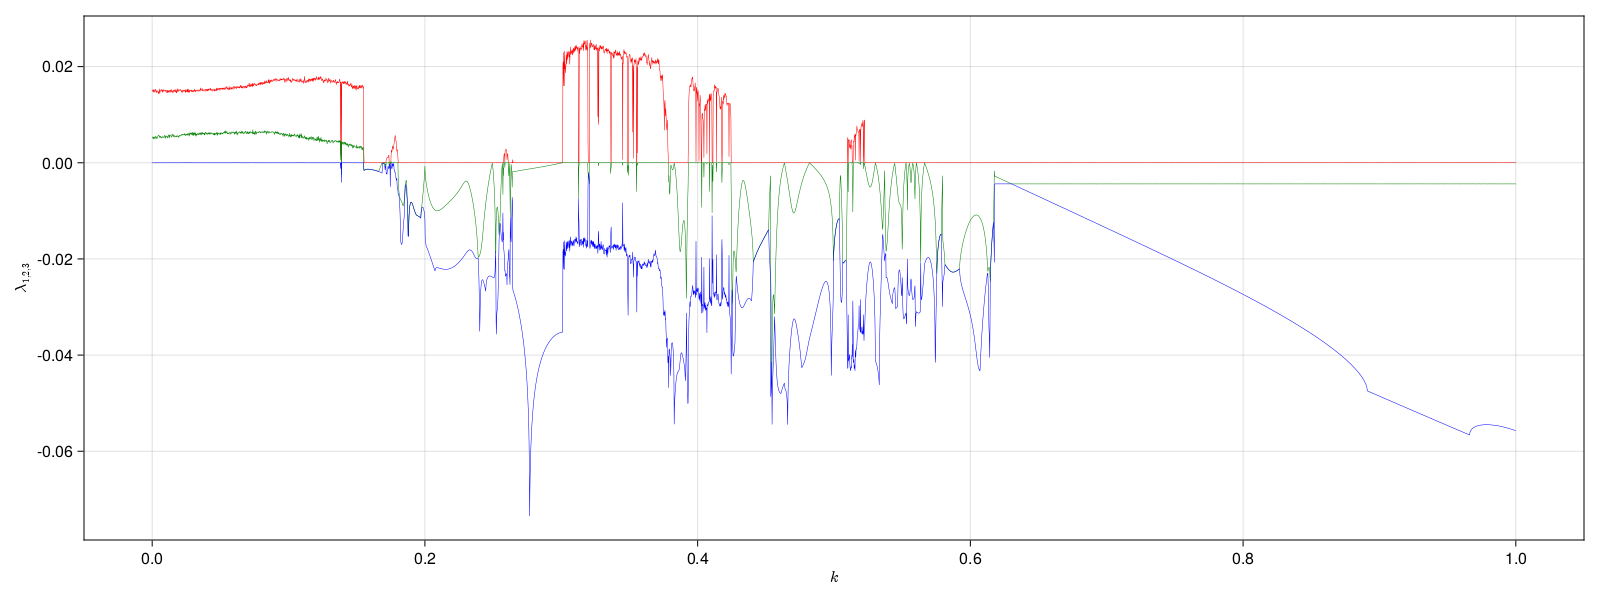

In [27]:
f = Figure(resolution = (1600, 600) )
ax = Axis(f[1, 1], xlabel = L"k", ylabel = L"\lambda_{1, 2, 3}")
limits = range(0.0, 1.0, step = 0.2)
ax.xticks = limits
lines!(ax, k_space, spectrum_array[1, :], linewidth = 0.5, color = "red")
lines!(ax, k_space, spectrum_array[2, :], linewidth = 0.5, color = "green")
lines!(ax, k_space, spectrum_array[3, :], linewidth = 0.5, color = "blue")
f

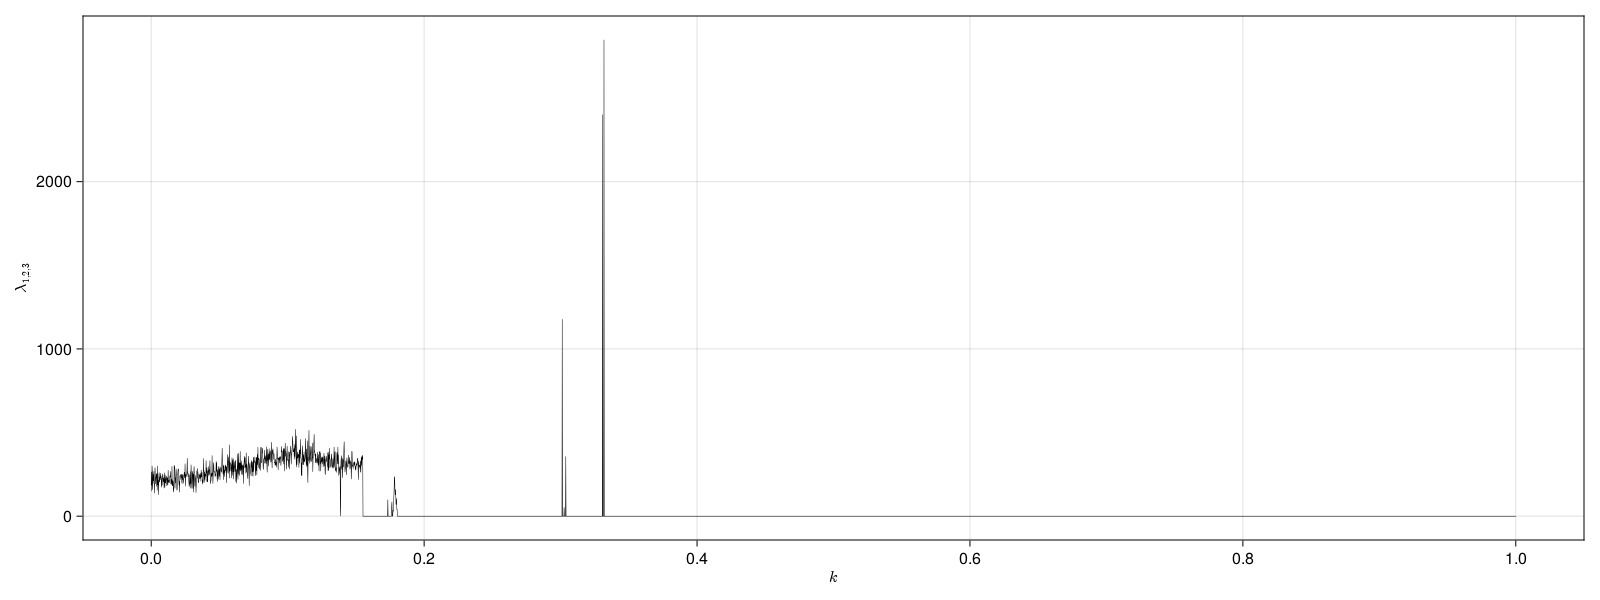

In [28]:
f = Figure(resolution = (1600, 600) )
ax = Axis(f[1, 1], xlabel = L"k", ylabel = L"\lambda_{1, 2, 3}")
limits = range(0.0, 1.0, step = 0.2)
ax.xticks = limits
lines!(ax, k_space, EVA_array, linewidth = 0.5, color = "black")

f